In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc
using MeshCat

  Activating environment at `C:\Users\ameys\Desktop\Spring '24\16-745_OptimalControlAndRL\16-745_Flying_Acrobot\Project.toml`


In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

In [3]:
#copied from RobotZoo src
function swinging_dynamics(params, x, u)
    g = 9.81
    m1,m2 = [1.,1.]
    l1,l2 = [1.,1.]
    J1,J2 = [1.,1.]
    θ1,    θ2    = x[3], x[4]
    θ1dot, θ2dot = x[7], x[8]
    s1,c1 = sincos(θ1)
    s2,c2 = sincos(θ2)
    c12 = cos(θ1 + θ2)

    # mass matrix
    m11 = m1*l1^2 + J1 + m2*(l1^2 + l2^2 + 2*l1*l2*c2) + J2
    m12 = m2*(l2^2 + l1*l2*c2 + J2)
    m22 = l2^2*m2 + J2
    M = [m11 m12; m12 m22]

    # bias term
    tmp = l1*l2*m2*s2
    b1 = -(2 * θ1dot * θ2dot + θ2dot^2)*tmp
    b2 = tmp * θ1dot^2
    B = [b1, b2]

    # friction
    c = 1.0
    C = [c*θ1dot, c*θ2dot]

    # gravity term
    g1 = ((m1 + m2)*l2*c1 + m2*l2*c12) * g
    g2 = m2*l2*c12*g
    G = [g1, g2]

    # equations of motion
    τ = [0, u[1]]
    θddot = M\(τ - B - G - C)
    return [0, 0, θ1dot, θ2dot, 0, 0, θddot[1], θddot[2]]
end


function f(params, q)
    #= 
    this function returns a new state vector [x1, y1, x2, y2, θ1, θ2], good for calculating M(q)
    x1, y1 = coordinates of C.O.M. of link 1
    x2, y2 = coordinates of C.O.M. of link 2
    θ1, θ2 = angle between axis of link and x-axis for links 1 and 2
    =#
    l1, l2 = params.l1, params.l2
    x, y, θ1, θ2 = q[1], q[2], q[3], q[4]
    s1,c1 = sincos(θ1)
    s2,c2 = sincos(θ2)
    s12, c12 = sincos(θ1 + θ2)
    return [x + l1/2*c1, y + l1/2*s1, x + l1*c1 + l2/2*c12, y + l1*s1 + l2/2*s12, θ1, θ2] 
end

function Mq(params, q)
    # returns the M(q) matrix used for Euler Lagrange equation
    m1,m2,I1,I2 = params.m1,params.m2,params.I1,params.I2
    M = diagm([m1,m1,m2,m2,I1,I2])
    δfδq = ForwardDiff.jacobian(dq -> f(params, dq), q)
    Mq = δfδq'*M*δfδq
    return Mq
end

function V(params, q)
    # returns the P.E. of the two-link system, used for calculting the B term in Euler Lagrange equation
    g = 9.81
    m1,m2,l1,l2 = params.m1,params.m2,params.l1, params.l2
    x, y, θ1, θ2 = q[1], q[2], q[3], q[4]
    s1,c1 = sincos(θ1)
    s2,c2 = sincos(θ2)
    s12, c12 = sincos(θ1 + θ2)
    V = m1*g*(y + l1/2*s1) + m2*g*(y + l1*s1 + l2/2*s12)
    return V
end

function flight_dynamics(params, x, u)
    #=
    dynamics of the two-link system while air-borne
    calculates qddot using Euler Lagrange equation
    returns ẋ
    =#
    nx = params.nx
    q = [x[i] for i = 1:4]
    q̇ = [x[i] for i = 5:8]
    
    # mass matrix and its derivative wrt q
    M_q = Mq(params, q)
    δMqδq = ForwardDiff.jacobian(dq -> vec(Mq(params, dq)), q)

    # N, C, τ terms
    N = ForwardDiff.gradient(dq -> V(params, dq), q)
    #size(kron(q̇', I(4)))
    #size(δMqδq)
    C = 1/2*(kron(q̇', I(4))*δMqδq*q̇)
    τ = [u[2], u[3], 0, u[1]]

    #equations of motion
    qddot = M_q \ (τ - N - C)
    return [q̇; qddot]
end

#=function flight_dynamics(params, x, u)
    #=
    dynamics of the two-link system while air-borne
    calculates qddot using Euler Lagrange equation
    returns ẋ
    =#
    nx = params.nx
    q = [x[i] for i = 1:4]
    q̇ = [x[i] for i = 5:8]
    
    # mass matrix and its derivative wrt q
    M_q = Mq(params, q)
    δMqδq = ForwardDiff.jacobian(dq -> vec(Mq(params, dq)), q)

    # N, C, τ terms
    N = ForwardDiff.gradient(dq -> V(params, dq), q)
    #size(kron(q̇', I(4)))
    #size(δMqδq)
    C = 1/2*(kron(q̇', I(4))*δMqδq*q̇)
    τ = [0, 0, 0, u[1]]

    #equations of motion
    qddot = M_q \ (τ - N - C)
    return [q̇; qddot]
end=#

function hermite_simpson(params::NamedTuple, dynamics::Function, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
    x_k_half = 0.5*(x1+x2) + (dt/8)*(dynamics(params, x1, u) - dynamics(params, x2, u))
    return x1 + (dt/6)*(dynamics(params, x1, u) + 4*dynamics(params, x_k_half, u) + 
        dynamics(params, x2, u)) - x2
end

hermite_simpson (generic function with 1 method)

In [39]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + (N) * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function swinging_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg, N1 = params.idx, params.N, params.xg, params.N1
    Q, R, Qf = params.Q, params.R, params.Qf
    
    # TODO: input cartpole LQR cost 
    
    J = 0 
    for i = 1:(N1-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        J += 1/2*(ui'*R*ui)
    end

    # dont forget terminal cost
    # xn = Z[idx.x[N]]
    # J += 1/2*(xn - xg)'*Qf*(xn - xg)    
    
    return J 
end

function swinging_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt, N1 = params.idx, params.N, params.dt, params.N1
    l1, l2 = params.l1, params.l2
    # TODO: create dynamics constraints using hermite simpson 
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, swinging_dynamics, xi, xip1, ui, dt)
    end
    xN = Z[idx.x[N]]
    v_cm = [ (-l1/2*xN[7]*sin(xN[3]) - l1*xN[7]*sin(xN[3]) - l2/2*xN[8]*sin(xN[3] + xN[4]))/2,
             (l1/2*xN[7]*cos(xN[3]) + l1*xN[7]*cos(xN[3]) + l2/2*xN[8]*cos(xN[3] + xN[4]))/2 ]
    c[idx.c[N]] = Z[idx.x[N+1]] - Z[idx.x[N]] - [0, 0, 0, 0, v_cm[1], v_cm[2], 0, 0]
    for i = N+1:N1-1
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, flight_dynamics, xi, xip1, ui, dt)
    end
        
    return c 
end

function swinging_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N1, idx, xic, xg = params.N1, params.idx, params.xic, params.xg 
    
    # TODO: return all of the equality constraints 
    equality_constraints = [Z[idx.x[1]] - xic;
        [Z[idx.x[N1]][1] - 2, Z[idx.x[N1]][1] - 0];
        swinging_dynamics_constraints(params, Z)]
    
    return equality_constraints # 10 is an arbitrary number 
end

swinging_equality_constraint (generic function with 1 method)

In [45]:
d = 2 # distance between bars
@show v = (d*9.81/(2*sin(pi/3)*cos(pi/3)))^0.5
t = d/(v*cos(pi/3))

v = ((d * 9.81) / (2 * sin(pi / 3) * cos(pi / 3))) ^ 0.5 = 4.759750472766499


0.8403801886015861

In [40]:
function solve_flight(;verbose = true)
    d = 2 # distance between bars
    v = (d*9.81/(2*sin(pi/3)*cos(pi/3)))^0.5
    t = d/(v*cos(pi/3))
    
    nx = 8
    nu = 1
    dt = 0.05
    tf = 5
    t_vec = 0:dt:tf 
    N = length(0:dt:tf-1)
    N1 = length(t_vec)

    #LQR cost
    Q = Diagonal([1.0*ones(2); 0.1*ones(2)]);
    R = 0.01;
    Qf = Array(10*I(nx));

    # indexing 
    idx = create_idx(nx,nu,N1)
    
    # initial and goal states 
    xic = [0, 0, 0, 0, 0, 0, 0, 0]
    xg = [2, 0, -pi/3, pi/3, v*cos(pi/3), -v*sin(pi/3), 0, 0]

    #load everything useful into params
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, N1 = N1, idx = idx, nx = nx, m1 = 1, m2 = 1, I1 = 1, I2 = 1, l1 = 1, l2 = 1)

    # TODO: primal bounds 
    x_l = -Inf*ones(idx.nz)
    x_u = Inf*ones(idx.nz)
    
    #=for i = 1:N-1
        x_l[idx.u[i]] .= -100
        x_u[idx.u[i]] .= 100
    end=#
    #@show x_l[idx.x[N1]] .= [1.9, -0.1, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf]
    #x_u[idx.x[N1]] .= [2.1, 0.1, Inf, Inf, Inf, Inf, Inf, Inf]
    #x_l[idx.x[N1]][1] = 1.9
    #x_l[idx.x[N1]][2] = -0.1
    #x_u[idx.x[N1]][1] = 2.1
    #x_u[idx.x[N1]][2] = 0.1
    # inequality constraint bounds (this is what we do when we have no inequality constraints)  
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end


    # initial guess 
    z0 = 0.001*randn(idx.nz)

    diff_type = :auto

    Z = fmincon(swinging_cost, swinging_equality_constraint, inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-3, c_tol = 1e-3, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N1]
    U = [Z[idx.u[i]] for i = 1:(N1-1)]
    
    return X, U, t_vec, params 
end

solve_flight (generic function with 1 method)

In [7]:
#@testset "cartpole swingup" begin 
    
#=X, U, t_vec = solve_swingup(verbose=true)


# --------------testing------------------
@test isapprox(X[1],[-pi/2, 0, 0, 0], atol = 1e-4)
@test isapprox(X[end], [-pi/4, pi/2, 0, 0], atol = 1e-4)
Xm = hcat(X...)
Um = hcat(U...)

# --------------plotting-----------------
display(plot(t_vec, Xm', label = ["p" "θ" "ṗ" "θ̇"], xlabel = "time (s)", title = "State Trajectory"))
display(plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls"))

# meshcat animation
display(animate_cartpole(X, 0.05))
    
#end+=#

In [41]:
#@testset "cartpole swingup" begin 

X, U, t_vec = solve_flight(verbose=true)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   735480
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      908
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      810
Total number of inequality constraints.......

([[-3.465805248293853e-17, -1.285641934910853e-17, 1.4017906256694472e-16, -8.446991264002043e-17, -1.3015062883684021e-16, 1.6200673848997452e-16, -1.396527606144052e-16, -1.0033499969833218e-16], [-6.931664023817123e-17, -2.5713371391647235e-17, -0.026442624532397787, 0.049584687554059856, -2.6029871529990376e-16, 3.2401374206698166e-16, -1.044094703282617, 1.954511348765007], [-1.0397461112422614e-16, -3.8569764338321416e-17, -0.10243373267114875, 0.1911064128353442, -3.90446214537773e-16, 4.860203003327604e-16, -1.9794621925720448, 3.6711067783590883], [-1.3863252226524247e-16, -5.1425998488176533e-17, -0.22163335226136696, 0.4104288230027427, -5.205927520990543e-16, 6.480287441611788e-16, -2.7656305721612875, 5.049014557619641], [-1.7329099641401337e-16, -6.427980351076113e-17, -0.3751968776952368, 0.6870373633684975, -6.507408469202301e-16, 8.100386221755469e-16, -3.3511258844269918, 5.952152703449458], [-2.0795090153963363e-16, -7.713321511003421e-17, -0.5528907926283676, 0.9960

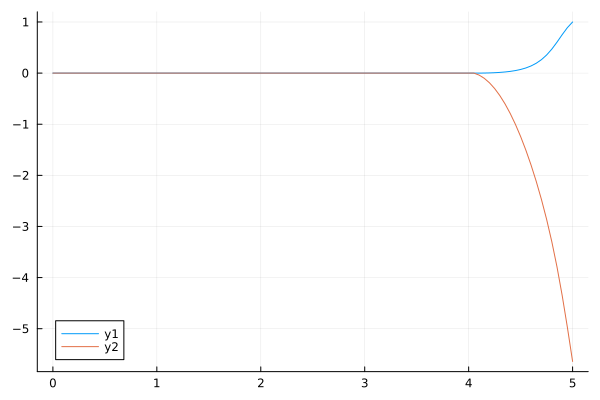

In [42]:
# plot x and y coordinates against time
Xm = [[X[i][1], X[i][2]] for i = 1:length(t_vec)]
Xm = hcat(Xm...)
plot(t_vec,Xm')

In [36]:
# Acrobot (doublependulum)
using Colors
function build_acrobot!(vis, color=colorant"blue", thick=0.05)
    l1,l2 = [1.,1.]
    hinge = MeshCat.Cylinder(MeshCat.Point3f(-0.05,0,0), MeshCat.Point3f(0.05,0,0), 0.05f0)
    dim1  = MeshCat.Vec(thick, thick, l1)
    link1 = MeshCat.HyperRectangle(MeshCat.Vec(-thick/2,-thick/2,0),dim1)
    dim2  = MeshCat.Vec(thick, thick, l2)
    link2 = MeshCat.HyperRectangle(MeshCat.Vec(-thick/2,-thick/2,0),dim2)
    mat1 = MeshPhongMaterial(color=colorant"grey")
    mat2 = MeshPhongMaterial(color=color)
    setobject!(vis["base"], hinge, mat1)
    setobject!(vis["link1"], link1, mat2) 
    setobject!(vis["link1","joint"], hinge, mat1) 
    setobject!(vis["link1","link2"], link2, mat2) 
    settransform!(vis["link1","link2"], MeshCat.Translation(0,0,l1))
    settransform!(vis["link1","joint"], MeshCat.Translation(0,0,l1))
end

function RotX(alpha)
    c, s = cos(alpha), sin(alpha)
    [1 0 0; 0 c -s; 0 s  c]
end
function update_acro_pose!(vis, x)
    l1, l2 = [1, 1.]
    settransform!(vis["robot","link1"], MeshCat.LinearMap(RotX(x[1]-pi/2)))
    settransform!(vis["robot","link1","link2"], MeshCat.compose(MeshCat.Translation(0,0,l1), MeshCat.LinearMap(RotX(x[2]))))
end

update_acro_pose! (generic function with 1 method)

In [43]:
dt = 0.05
N = 81
vis = Visualizer()
build_acrobot!(vis["robot"])
anim = MeshCat.Animation(floor(Int, 1 / dt))

for k = 1:N
    MeshCat.atframe(anim, k) do
        update_acro_pose!(vis, X[k][3:4])
        
    end
end
MeshCat.setanimation!(vis, anim)
render(vis)

[ Info: Listening on: 127.0.0.1:8719, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8719


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x62, 0x61, 0x73, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("joint" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "link2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x6e, 0x6b, 0x31, 0x2f, 0x6c, 0x69, 0x6e, 0x6b, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8719))